<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction


**What?** Getting prediction interval from random forest and XGBoost



# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
import numpy as np
import pandas as pd
import copy
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import callbacks

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 16

# Import dataset
<hr style="border:2px solid black"> </hr>


- There are 9 days.
- Each day has 24 hrs. The observation has registered every hour.
- The total number of instances is: 9*24 = 216 points.



In [2]:
ads_col = 'Ads'
time_col = 'Time'
input_path = "./ads.csv"
ads = pd.read_csv(input_path, index_col=time_col, parse_dates=[time_col])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


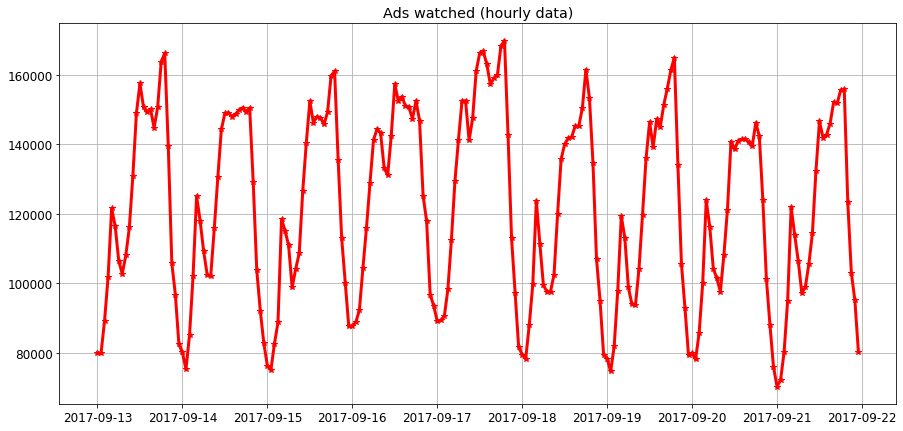

In [3]:
rcParams['font.size'] = 12
#register_matplotlib_converters()
plt.figure(figsize = (15, 7))
plt.plot(ads[ads_col], "r*-", lw = 3)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

# Features engineering
<hr style="border:2px solid black"> </hr>


- Generating lagged features and window statistics from them.
- We will also add date & time features such as hour of the day, day of the week and a boolean feature indicating whether this is a weekend.
- **Window statistics**: mean of the lagged features we've created.



In [4]:
label_col = 'y'
data = pd.DataFrame(ads[ads_col].copy())
data.columns = [label_col]

# Add the lag of the target variable from 6 steps back up to 24
# 24 means 25 hours thus one day
for i in range(6, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)

data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
# 5 and 6 means Saturday and Sunday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)

data = data.dropna()
data.head()

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_6551/1191971357.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)


,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0


In [5]:
data.shape

(192, 23)

In [6]:
dataAll = copy.deepcopy(data)

In [7]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()

dimension:  (192, 23)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,124731.052632
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,129263.684211
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,132402.368421
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,133274.473684
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,133003.421053


In [8]:
pd.DataFrame(y)

,0
0,80125
1,75335
2,85105
3,102080
4,125135
...,...
187,155890
188,123395
189,103080
190,95155


# Split the data
<hr style="border:2px solid black"> </hr>

In [9]:
def timeseries_train_test_split(X, y, test_size=0.3):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

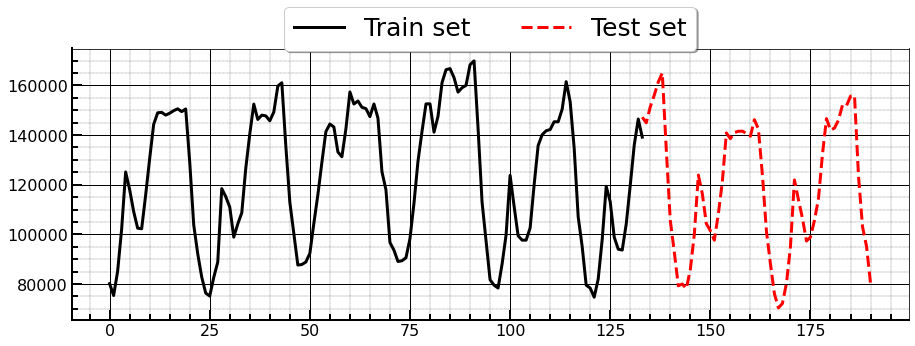

In [11]:
rcParams['font.size'] = 16

x_train = range(y_train.size)
# Adding a shift
x_test = [i + max(x_train) for i in range(y_test.size)]

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(x_train, y_train, "k-", lw = 3, label = 'Train set')
plt.plot(x_test, y_test, "r--", lw = 3, label = 'Test set')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.2),
          ncol = 2, fontsize = 25, fancybox=True, shadow=True)
ax.grid(True)

# Models
<hr style="border:2px solid black"> </hr>


- We are not optimising the model at this points.
- We'll try three different models:
    - Random forest
    - XGBoost
    


## Random forest

In [12]:
model = RandomForestRegressor(max_depth = 6, n_estimators = 25)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
predictionTrain = model.predict(X_train)

In [25]:
X_train

array([[1.63840000e+05, 1.50690000e+05, 1.44780000e+05, ...,
        3.00000000e+00, 0.00000000e+00, 1.24731053e+05],
       [1.66235000e+05, 1.63840000e+05, 1.50690000e+05, ...,
        3.00000000e+00, 0.00000000e+00, 1.29263684e+05],
       [1.39520000e+05, 1.66235000e+05, 1.63840000e+05, ...,
        3.00000000e+00, 0.00000000e+00, 1.32402368e+05],
       ...,
       [1.13115000e+05, 1.19345000e+05, 9.79500000e+04, ...,
        1.00000000e+00, 0.00000000e+00, 1.20927105e+05],
       [9.88800000e+04, 1.13115000e+05, 1.19345000e+05, ...,
        1.00000000e+00, 0.00000000e+00, 1.18986316e+05],
       [9.40000000e+04, 9.88800000e+04, 1.13115000e+05, ...,
        1.00000000e+00, 0.00000000e+00, 1.16558947e+05]])

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
error = mean_absolute_percentage_error(prediction, y_test)
errorTrain = mean_absolute_percentage_error(predictionTrain, y_train)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(error))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrain))

Mean absolute percentage [TEST] error 4.19%
Mean absolute percentage [TRAIN] error 2.49%


**Learning curves**

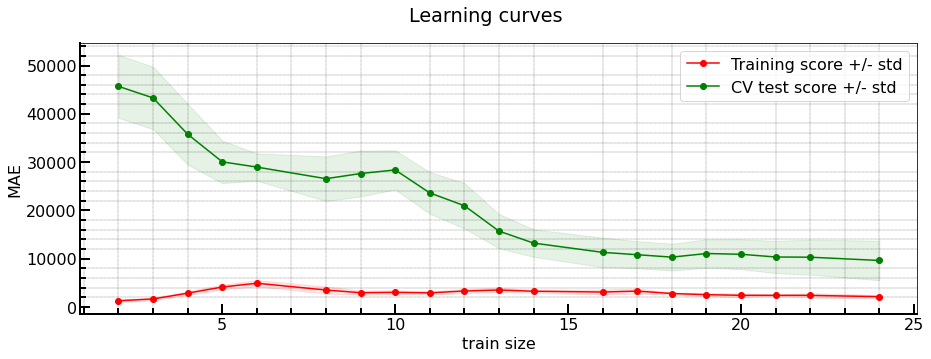

In [15]:
timeseries_cv = TimeSeriesSplit(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train,
                                                        cv=timeseries_cv,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(
                                                            0.1, 1, 20),
                                                        scoring="neg_mean_absolute_error")

train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = -1*np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(test_scores, axis=1)
test_scores_std = -1*np.std(test_scores, axis=1)


# Plot learning curve
fig = plt.figure()
fig.suptitle("Learning curves")
ax = fig.add_subplot(111)

ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1,
                color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score +/- std")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="CV test score +/- std")

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("train size")
ax.set_ylabel("MAE")

plt.legend(loc="best")
plt.grid()

## XGBoost

In [16]:
eval_set = [(X_train, y_train), (X_test, y_test)]
modelXGB = XGBRegressor(objective='reg:squarederror',
                        max_depth=6,
                        n_estimators=50)
a = modelXGB.fit(X_train, y_train, eval_metric="mae", eval_set=eval_set)

resultsXGB = modelXGB.evals_result()

[0]	validation_0-mae:86526.50140	validation_1-mae:84048.88706
[1]	validation_0-mae:61207.74843	validation_1-mae:58976.67922
[2]	validation_0-mae:43307.18149	validation_1-mae:41687.36099
[3]	validation_0-mae:30659.24761	validation_1-mae:28958.94154
[4]	validation_0-mae:21832.42339	validation_1-mae:21129.99286
[5]	validation_0-mae:15577.66803	validation_1-mae:15364.91474
[6]	validation_0-mae:11221.06046	validation_1-mae:12113.67955
[7]	validation_0-mae:8161.25548	validation_1-mae:10208.86422
[8]	validation_0-mae:5964.03481	validation_1-mae:8557.68750
[9]	validation_0-mae:4390.56786	validation_1-mae:7834.64763
[10]	validation_0-mae:3225.47132	validation_1-mae:7555.09092
[11]	validation_0-mae:2394.88771	validation_1-mae:7215.54081
[12]	validation_0-mae:1815.73059	validation_1-mae:7074.84739
[13]	validation_0-mae:1411.82678	validation_1-mae:6918.90652
[14]	validation_0-mae:1148.73828	validation_1-mae:6818.88376
[15]	validation_0-mae:969.16389	validation_1-mae:6712.08742
[16]	validation_0-ma

/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [17]:
predictionTestXGB = modelXGB.predict(X_test)
predictionTrainXGB = modelXGB.predict(X_train)

In [18]:
errorTestXGB = mean_absolute_percentage_error(predictionTestXGB, y_test)
errorTrainXGB = mean_absolute_percentage_error(predictionTrainXGB, y_train)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestXGB))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainXGB))

Mean absolute percentage [TEST] error 5.59%
Mean absolute percentage [TRAIN] error 0.01%


**Learning curves**

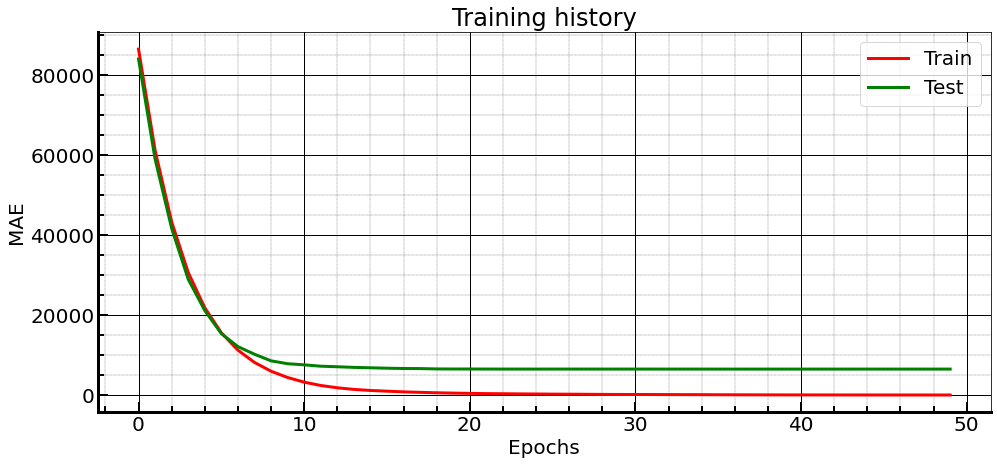

In [19]:
epochs = len(resultsXGB['validation_0']["mae"])
x_axis = range(0, epochs)

rcParams['figure.figsize'] = 16, 7
rcParams['font.size'] = 20

fig, ax = plt.subplots()
ax.plot(x_axis, resultsXGB['validation_0']["mae"], 'r-', lw=3, label='Train')
ax.plot(x_axis, resultsXGB['validation_1']["mae"], 'g', lw=3, label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel("MAE")
plt.title('Training history')

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.minorticks_on()
plt.show()

# Plotting
<hr style="border:2px solid black"> </hr>

## Comparing train + test sets

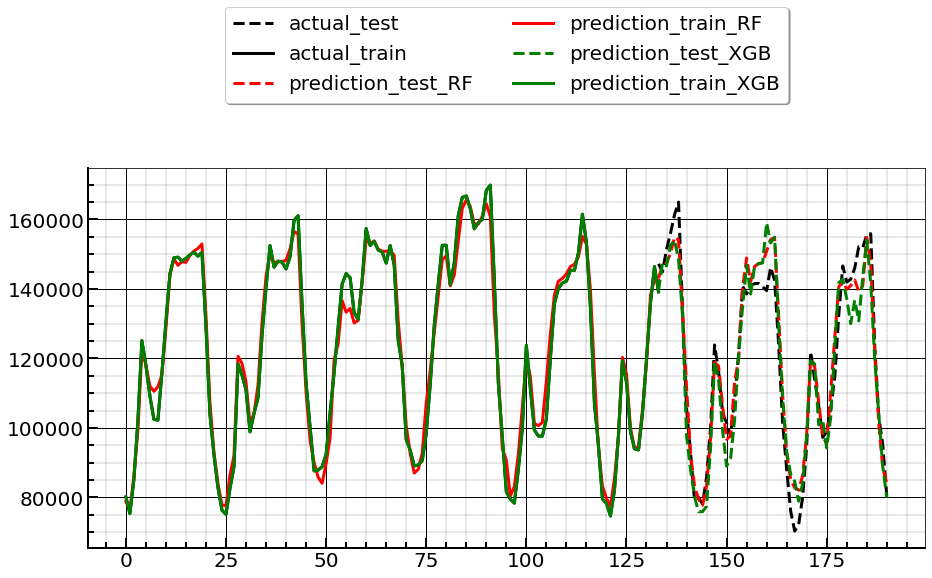

In [20]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

x_train = range(y_train.size)
x = [i + max(x_train) for i in range(prediction.size)]

# Train and test sets
plt.plot(x, y_test, "k--", lw=3, label='actual_test')
plt.plot(x_train, y_train, "k-", lw=3, label='actual_train')

# Random Forest results
plt.plot(x, prediction, "r--", lw=3, label='prediction_test_RF')
plt.plot(x_train, predictionTrain, "r-", lw=3, label='prediction_train_RF')

# XGBoost results
plt.plot(x, predictionTestXGB, "g--", lw=3, label='prediction_test_XGB')
plt.plot(x_train, predictionTrainXGB, "g-", lw=3, label='prediction_train_XGB')

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=2, fancybox=True, shadow=True)

plt.grid(True)

## Comparing test set only

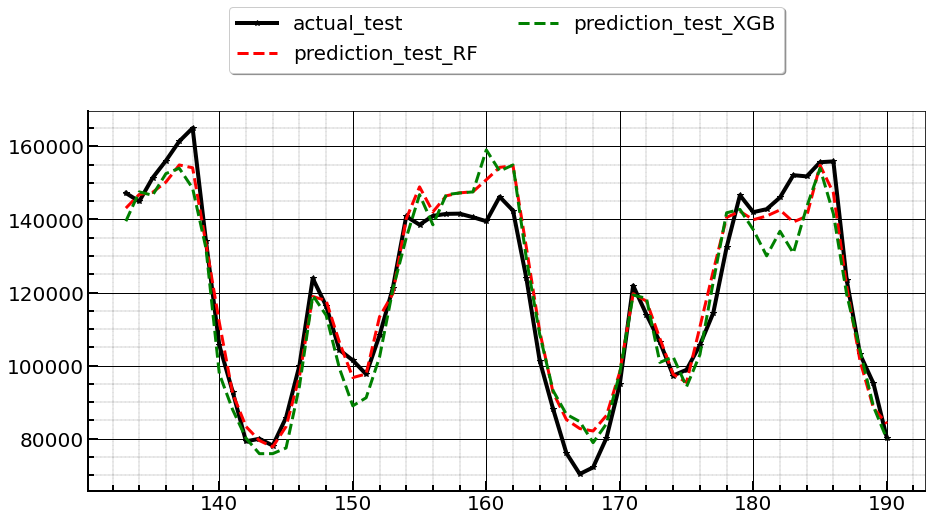

In [21]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

x_train = range(y_test.size)

# Train and test sets
plt.plot(x, y_test, "k*-", lw=4, label='actual_test')

# Random Forest results
plt.plot(x, prediction, "r--", lw=3, label='prediction_test_RF')

# XGBoost results
plt.plot(x, predictionTestXGB, "g--", lw=3, label='prediction_test_XGB')

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True)

plt.grid(True)

# Forecast with prediction intervals
<hr style="border:2px solid black"> </hr>


- The way we are getting the prediction interval here is a bit unusual but still valid.
- We are pulling out the standard deviation from the cross validation procedure.
- **For me there is still a question whethere this approach is appropriate or not?**



In [22]:
def get_PI(model_):
    """Get prediction interval.

    Since we are calling this step more than once,
    I create a funcion just for it.
    """

    timeseries_cv = TimeSeriesSplit(n_splits=5)

    cv = cross_val_score(model_,
                         X_train, y_train,
                         cv=timeseries_cv,
                         scoring='neg_mean_absolute_error')
    mae = -1 * cv.mean()
    deviation = cv.std()

    # Hard-coded 95% prediction interval
    scale = 1.96
    margin_error = mae + scale * deviation
    lower = prediction - margin_error
    upper = prediction + margin_error

    return lower, upper

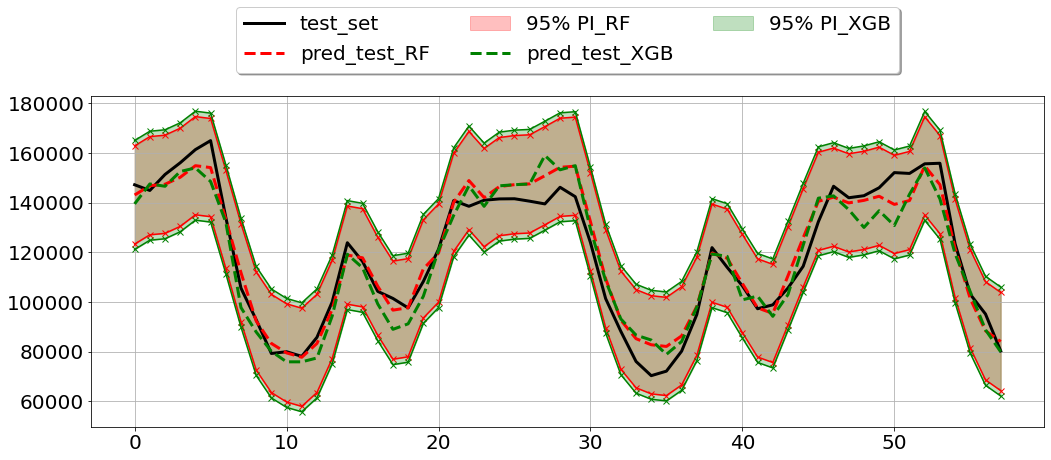

In [23]:
plt.figure(figsize=(15, 7))
x = range(prediction.size)
fill_alpha = 0.5
fill_color = 'yellow'

# Plotting target
plt.plot(x, y_test, "k-", lw=3, label='test_set')

# Random Forest results
plt.plot(x, prediction, "r--", lw=3, label='pred_test_RF')
lower, upper = get_PI(model)
plt.fill_between(x, lower, upper, color="r", alpha=0.25, label='95% PI_RF')

# XGBoost results
plt.plot(x, predictionTestXGB, "g--", lw=3, label='pred_test_XGB')
lowerXGB, upperXGB = get_PI(modelXGB)
plt.fill_between(x, lowerXGB, upperXGB, color="g",
                 alpha=0.25, label='95% PI_XGB')

plt.plot(x, upper, "xr-")
plt.plot(x, lower, "xr-")

plt.plot(x, upperXGB, "xg-")
plt.plot(x, lowerXGB, "xg-")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
           ncol=3, fancybox=True, shadow=True)

plt.tight_layout()
plt.grid(True)


- **If nothing unexpected happens we expect to be within ±x %, but if assumptions a, b, or c perform differently than expected, we might be as much as ±y% off.**

- For the **±x%** part, notice that in this documentation, we added a confidence interval functionality to our time series forecasting plot. This is where the confidence interval part can come in handy.
- Whereas Monte Carlo simulation can come in handy for the second part of the sentence **±y %** (if assumptions a, b, or c perform differently ...). 



# Conclusions
<hr style="border:2px solid black"> </hr>


- Confidence and prediction intervals are not the same thing.



# References
<hr style="border:2px solid black"> </hr>


- [Blog: Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
- [Blog: How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
- [Blog: Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
- [Blog: What's wrong with my time series? Model validation without a hold-out set
](https://blog.insightdatascience.com/whats-wrong-with-my-time-series-model-validation-without-a-hold-out-set-94151d38cf5b)
- [Jupyter Notebook: Open Machine Learning Course - Time series analysis in Python](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)
- [This notebook](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/time_series/3_supervised_time_series.ipynb)

